In [7]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
plt.style.use('default')
cmap =  ListedColormap(["darkorange", "magenta", "lightseagreen"])

import distance_metrics

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# K - Nearest Neighbors

Use a number of points that are closest to a sample to predict its class.    
For example if the 5 nearest neighbors of sample a are 2 times class 1 and 3 times class 2, KNN will predict that sample a has the class 2.

### Definition of KNN class

In [8]:
class KNN:
    """
    K-Nearest Neighbors is a supervised learning algorithm.
    When presented with a new data point of which the label is not known this method will determine the
    k - nearest neighbors by a chosen distance metric and predict the majority label.
    """
    def __init__(self, knearest=3, distance="euclidian", p=2):
        #Note to self, the instance variable does not need an underscore here, only in the setter and getter
        self.knearest = knearest
        self.distance = distance
        self.p = p

    @property
    def p(self):
        return self._p
    
    @p.setter
    def p(self, p):
        if not isinstance(p ,int) or p < 1:
            raise ValueError("P (as used for the minkowski distance) should be a number and larger than 0.")
        self._p = p

    @property
    def distance(self):
        return self._distance
    
    @distance.setter
    def distance(self, distance):
        if distance not in ["euclidian", "manhattan", "minkowski", "chebyshev", "cosine", "hamming", "jaccard"]:
            raise ValueError("Please choose one of the following distance measures: euclidian, manhattan, minkowski, chebyshev, cosine, hamming or jaccard.")
        self._distance = distance

    @property
    def knearest(self):
        return self._knearest
    
    @knearest.setter
    def knearest(self, knearest):
        if not isinstance(knearest,int):
            raise ValueError("Please enter a whole number.")
        elif knearest <= 0:
            raise ValueError("Please enter a number larger than 0.")
        self._knearest = knearest


    def fit(self, X, y):
        self.X_train = X
        self.y_train = y


    def predict(self, samples):
        predicted_labels = [self._predict(x) for x in samples]
        return np.array(predicted_labels)
        
    def _predict(self, sample):
        # compute the distances between the sample the training data
        # Find the k nearest neighbors
        # Chose the label according to majority vote

        #idea limit the points you compute the distance for to sample_var +/- std or variance
        distances = self.compute_dist(sample)
        k_nearest_idx = self._get_k_nearest(distances)
        label = self._get_majority_label(k_nearest_idx)
        return label
    
    # Possibility to add weighted distance: the closer a point the more influence it has on the predicted value
    # Also try other methods rather than brute force computation, starting point Kdtree, ball_tree as in sklearn
    def compute_dist(self, sample):
        distances = {}
        match self.distance:
            case "euclidian":
                return [euclidian_dist(x, sample) for x in self.X_train]
            case  "manhattan" :
                return [manhattan_dist(x, sample) for x in self.X_train]
            case "minkowski" :
                return [minkowski_dist(x, sample) for x in self.X_train]
            case "chebyshev":
                return [chebyshev_dist(x, sample) for x in self.X_train]
            case "cosine":
                return [cosine_distance(x, sample) for x in self.X_train]
            case "hamming":
                return [hamming_distance(x, sample) for x in self.X_train]
            case "jaccard":
                return [jaccard_distance(x, sample) for x in self.X_train]
        
    
    def _get_k_nearest(self, distances):
        sorted_neighbors = np.argsort(distances)
        return sorted_neighbors[:self.knearest]
    
    def _get_majority_label(self, k_nearest_idx):
        labels = []
        for neighbor in k_nearest_idx:
            labels.append(self.y_train[neighbor])
        return Counter(labels).most_common()[0][0]

### Some basic performance metrics

TODO make own graphic that is a bit easier to understand and isn't so visually cluttered

<img src="performance_metrics.png" width="1200" height="600" />

In [9]:
# classification report returns does precision, recall, f1 and accuracy plus support, macro and weighted average

def mean_absolute_error(predicted, target):
    return ( np.sum([abs(t-p) for t,p in zip(target, predicted)]) / len(predicted) )

def accuracy(predicted, target):
    # ( TP + TN ) / ( all )
    return np.sum(predicted == target) / len(target)

def precision(predicted, target):
    # True positive / all predicted as positive
    # TP / ( TP + FP )
    pass

def recall(predicted, target):
    # True positive / all that should be predicted positive
    # TP / ( TP + FN )
    pass




### Test on iris data set

train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])     
will shuffle the data, split at 60% train, 20% valid, 20% test

In [10]:
iris = datasets.load_iris()

X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

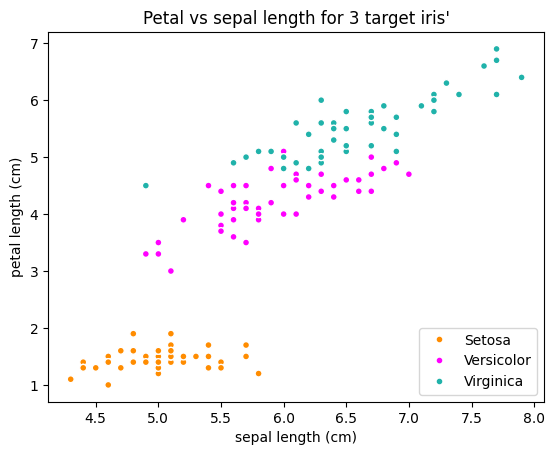

In [11]:
plt.figure()
plt.title("Petal vs sepal length for 3 target iris'")
scatter = plt.scatter(X[:,0], X[:,2], c=y, cmap=cmap, edgecolors='w', s=25)
plt.ylabel(iris.feature_names[2])
plt.xlabel(iris.feature_names[0])
# plt.legend([0,1,2], labels=["darkorange", "magenta", "lightseagreen"])
custom = [Line2D([], [], marker='.', color="darkorange", linestyle='None'),
          Line2D([], [], marker='.', color="magenta", linestyle='None'),
          Line2D([], [], marker='.', color="lightseagreen", linestyle='None')]
plt.legend(handles = custom, labels=['Setosa', 'Versicolor', 'Virginica'], loc= "lower right")
plt.show()

In [12]:
model = KNN(2, distance="cosine")
model.fit(X_train, y_train)
predicted = model.predict(X_test)

print("Mean absolute error: ", mean_absolute_error(predicted, y_test))
print("Accuracy: ", accuracy(predicted, y_test))

print(classification_report(y_test, predicted))
# here we see for example that the precision for predicting class 1 is slightly lower.

NameError: name 'cosine_distance' is not defined

In [ ]:

# KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
model_comp = KNeighborsClassifier(2, metric="cosine")
model_comp.fit(X_train, y_train)

predicted_comp = model_comp.predict(X_test)

print("Mean absolute error: ", mean_absolute_error(predicted_comp, y_test))
print("Accuracy: ", accuracy(predicted_comp, y_test))




Mean absolute error:  0.06666666666666667
Accuracy:  0.9333333333333333
